In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
# %matplotlib qt
import sys
sys.path.append('C:\code\qdc2')

import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
from fiber import Fiber

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Guided modes: 13


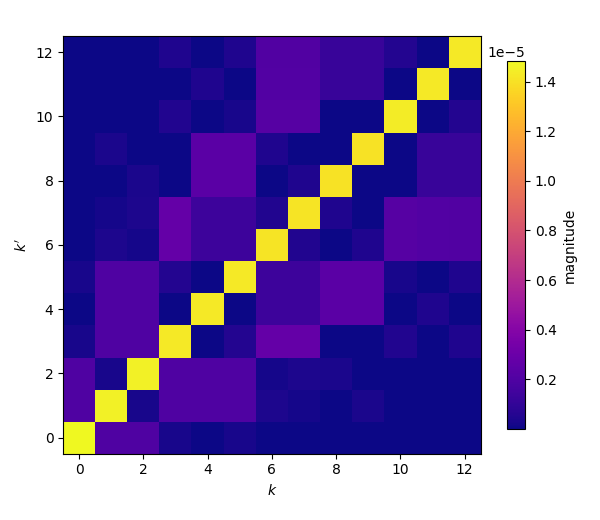

q-range: [-4.053, 3.990]  Δq = 0.062349
max |diag|        : 1.483e-05
min |diag|        : 1.404e-05
max |off-diag|    : 2.752e-06
ratio off/diag    : 1.855e-01
||C-C†|| / ||C||  : 1.419e-07
Schmidt number    : 13.0
Δ-kernel uniformity (std/mean): 1.559e-02


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift

# ------------------------------------------------------------------
# integration ------------------------------------------------------
# ------------------------------------------------------------------
def coeff_matrix_chunked(fib, sigma, b2, chunk=2048):
    dx      = fib.dx
    n       = fib.npoints
    dq      = 2*np.pi/(n*dx)
    nq      = n**2

    # Fourier modes -------------------------------------------------
    Mxy  = fib.modes.getModeMatrix()
    m    = Mxy.shape[1]
    F    = np.empty((m, nq), np.complex64)
    for k in range(m):
        F[k] = fftshift(fft2(Mxy[:, k].reshape(n, n), norm='ortho')).ravel()

    # q-grid --------------------------------------------------------
    q1d  = (np.arange(n) - n//2) * dq
    Qx, Qy = np.meshgrid(q1d, q1d, indexing='ij')
    qx, qy = Qx.ravel().astype(np.float32), Qy.ravel().astype(np.float32)
    # qx -= qx.mean()
    # qy -= qy.mean()

    # full ψ (nq × nq) computed once --------------------------------
    qsx, qsy = qx[:, None], qy[:, None]
    PSI = np.exp(
        -((qsx + qx)**2 + (qsy + qy)**2) / (2 * sigma**2)
        -  b2 * ((qsx - qx)**2 + (qsy - qy)**2)
    ).astype(np.float32)

    # accumulate C --------------------------------------------------
    C = np.zeros((m, m), np.complex64)
    for s in range(0, nq, chunk):
        e    = min(s + chunk, nq)
        temp = F.conj() @ PSI[:, s:e]       # (m × chunk)
        C   += temp @ F[:, s:e].T
    C *= dq**4

    meta = {"dq": dq, "qx_min": q1d.min(), "qx_max": q1d.max()}
    return C, meta

# ------------------------------------------------------------------
# diagnostics + viz ------------------------------------------------
# ------------------------------------------------------------------
def show_results(C, meta, use_delta_kernel=False):
    absC   = np.abs(C)
    diag   = np.abs(np.diag(C))
    offmax = (absC - np.diag(diag)).max()

    # heat-map ------------------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 5.2))
    im      = ax.imshow(absC, origin='lower', cmap='plasma')
    ax.set_xlabel(r'$k$')
    ax.set_ylabel(r"$k'$")
    plt.colorbar(im, ax=ax, shrink=0.8, label='magnitude')
    plt.tight_layout()
    plt.show()

    # numbers -------------------------------------------------------
    print(f"q-range: [{meta['qx_min']:.3f}, {meta['qx_max']:.3f}]  Δq = {meta['dq']:.6f}")
    print(f"max |diag|        : {diag.max():.3e}")
    print(f"min |diag|        : {diag.min():.3e}")
    print(f"max |off-diag|    : {offmax:.3e}")
    print(f"ratio off/diag    : {offmax/diag.max():.3e}")

    herm = np.linalg.norm(C - C.conj().T) / np.linalg.norm(C)
    s    = np.linalg.svd(C, compute_uv=False)
    K    = (s.sum()**2) / (s @ s)
    print(f"||C-C†|| / ||C||  : {herm:.3e}")
    print(f"Schmidt number    : {K:.1f}")

    if use_delta_kernel:
        print(f"Δ-kernel uniformity (std/mean): {diag.std()/diag.mean():.3e}")

# ------------------------------------------------------------------
# parameter cell (edit only here) ----------------------------------
# ------------------------------------------------------------------
λ_sig   = 0.808      # µm
core_d  = 25         # µm
NA      = 0.10
grid_n  = 130

fib = Fiber(wl=λ_sig, diameter=core_d, NA=NA, npoints=grid_n, autosolve=True, areaSize=4*core_d)
print(f"Guided modes: {fib.Nmodes}")

use_delta_kernel = True
if use_delta_kernel:
    sigma, b2 = 1e-6, 1e-12         # δ-like
else:
    mag       = 10
    real_space_sigma = 500.0 / mag
    sigma     = 2 / real_space_sigma
    wl_p      = 0.404
    n_crystal = 1.8
    k_p       = 2 * np.pi * n_crystal / wl_p
    L_cr      = 2000.0
    b2        = (L_cr / (4 * k_p)) / mag**2

    dx      = fib.dx
    n       = fib.npoints
    dq      = 2*np.pi/(n*dx)
    print(f"sigma_pix={sigma/dq:.2f}  (want 2-30)   b_pix={1/np.sqrt(b2)/dq:.2f}  (want 2-30)")

# run + display ----------------------------------------------------
C, meta = coeff_matrix_chunked(fib, sigma, b2, chunk=256)
show_results(C, meta, use_delta_kernel)


In [103]:
dx      = fib.dx
n       = fib.npoints
dq      = 2*np.pi/(n*dx)
nq      = n**2

# Fourier modes -------------------------------------------------
Mxy  = fib.modes.getModeMatrix()
m    = Mxy.shape[1]
F    = np.empty((m, nq), np.complex64)

# q-grid --------------------------------------------------------
q1d  = (np.arange(n) - n//2) * dq
Qx, Qy = np.meshgrid(q1d, q1d, indexing='ij')
qx, qy = Qx.ravel().astype(np.float32), Qy.ravel().astype(np.float32)
qx -= qx.mean()
qy -= qy.mean()

sigma = 2 / 50
b2 = 30
# full ψ (nq × nq) computed once --------------------------------
qsx, qsy = qx[:, None], qy[:, None]
PSI = np.exp(
    -((qsx + qx)**2 + (qsy + qy)**2) / (2 * sigma**2)
    -  b2 * ((qsx - qx)**2 + (qsy - qy)**2)
).astype(np.float32)



In [ ]:
16900**2


285610000

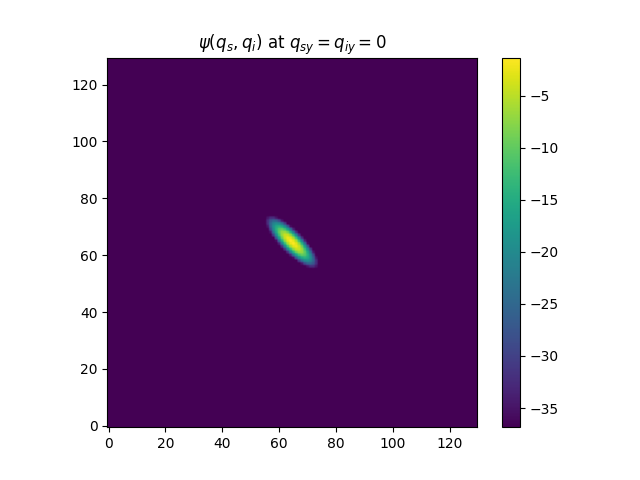

In [104]:
grid_n = int(np.sqrt(PSI.shape[0]))  # assuming square 2D grid
PSI_2D = PSI.reshape(grid_n, grid_n, grid_n, grid_n)

# Select qy=0 and qi=qj diagonal
center = grid_n // 2
psi_diag = PSI_2D[center, :, center, :]

fig, ax = plt.subplots()
imm = ax.imshow(np.log(np.abs(psi_diag) + 1e-16), origin='lower')
fig.colorbar(imm, ax=ax)
ax.set_title(r"$\psi(q_s, q_i)$ at $q_{sy}=q_{iy}=0$")
plt.show()

In [84]:
np.unravel_index(PSI.argmax(), PSI.shape)

(4551, 12348)

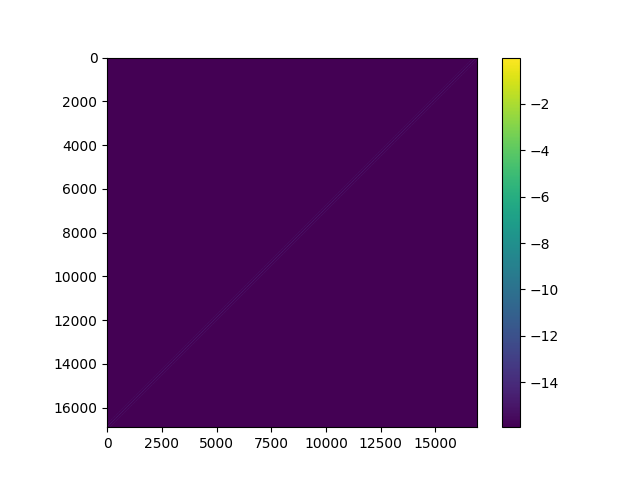

In [87]:
fig, ax = plt.subplots()
imm = ax.imshow(np.log(np.abs(PSI+np.finfo(np.float32).eps)))
fig.colorbar(imm, ax=ax)
plt.show()

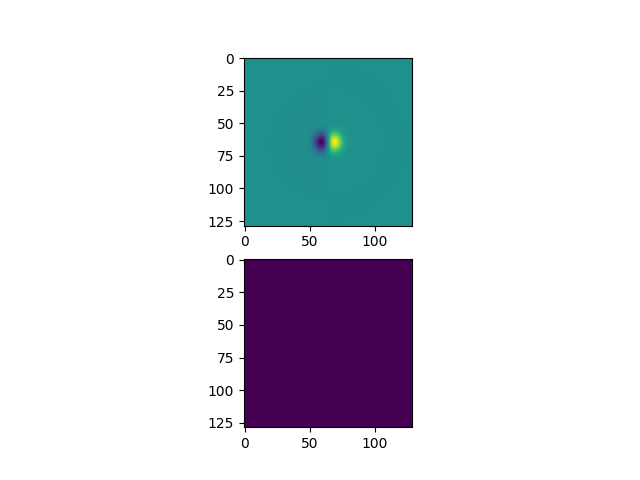

In [66]:
fib.show_mode(1)

In [11]:
nq = fib.npoints**2
Mxy  = fib.modes.getModeMatrix()
m    = Mxy.shape[1]
F    = np.empty((m, nq), np.complex64)
for k in range(m):
    F[k] = fftshift(fft2(Mxy[:, k].reshape(n, n), norm='ortho')).ravel()

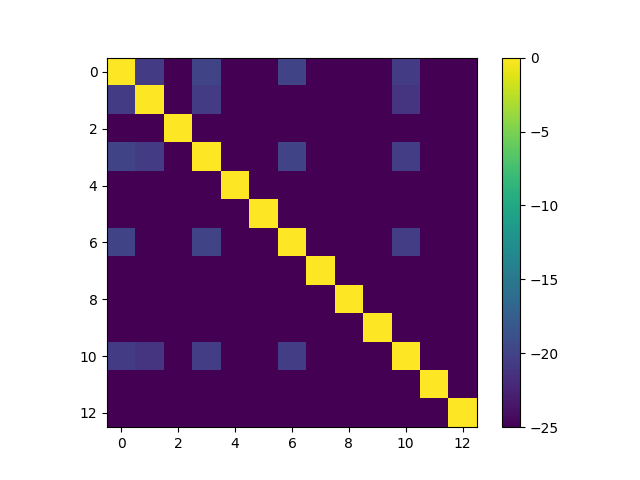

In [36]:
overlap_xy = Mxy.conj().transpose() @ Mxy 
overlap_xy_I = np.abs(overlap_xy)**2
fig, ax = plt.subplots()
imm = ax.imshow(np.log(overlap_xy_I), vmin=-25)
fig.colorbar(imm, ax=ax)

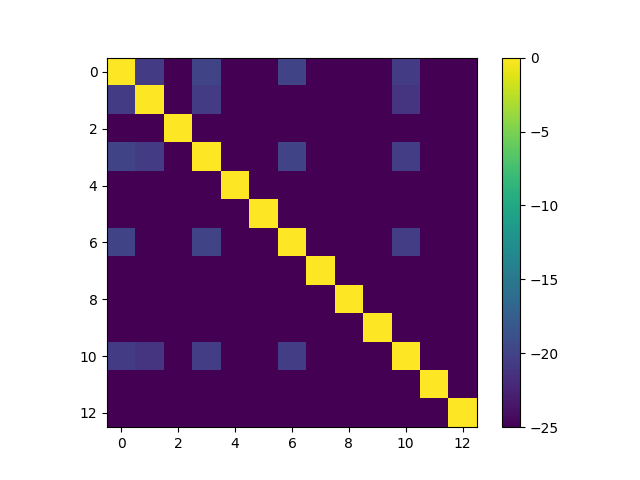

In [37]:
overlap_F = F.conj().transpose() @ F 
overlap_F_I = np.abs(overlap_F)**2
fig, ax = plt.subplots()
imm = ax.imshow(np.log(overlap_xy_I), vmin=-25)
fig.colorbar(imm, ax=ax)

In [ ]:
i = 0

np.max(np.abs(F[:, ::-1] -  F.conj()))
# np.allclose(Mxy[:, ::-1], Mxy.conj())

1.1368684e-13

In [63]:
I_F.shape

(129, 129)

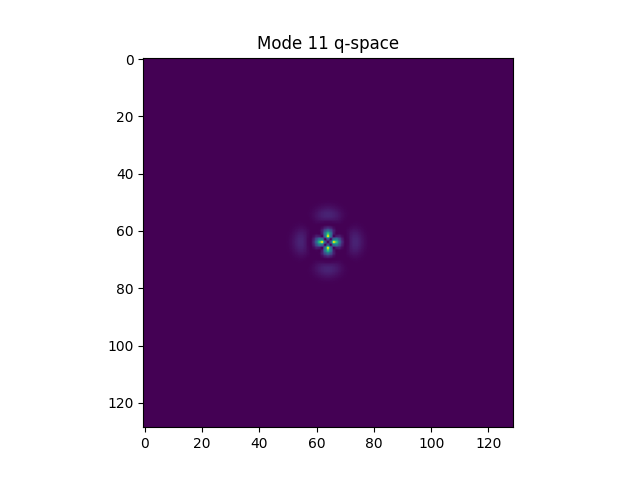

In [62]:
i = 11
I_F = np.abs(F[i].reshape(grid_n, grid_n))**2
fig, ax = plt.subplots()
ax.imshow(I_F)
ax.set_title(f"Mode {i} q-space")
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft

# ---------- parameters you tweak ----------
nq     = 2048        # grid points (1-D)
Lq = 4.0        # ±4 covers >99% of a σ=0.3 Gaussian in q-space
sigma  = 0.3
b2     = 25.0
modes  = 6           # how many HG modes to keep
# ------------------------------------------

dq     = 2*Lq/nq
q      = np.linspace(-Lq, Lq-dq, nq)

# real-space HG modes  --------------------------------------------
def HG(k, x, w=1.0):
    from scipy.special import eval_hermite
    norm = (1/np.sqrt(2**k * np.math.factorial(k) * np.sqrt(np.pi)*w))
    return norm * eval_hermite(k, x/(w/np.sqrt2)) * np.exp(-x**2/(2*w**2))

x      = np.linspace(-Lq, Lq, nq)
Fx     = fftshift(fft(HG(np.arange(modes)[:,None], x), axis=1, norm='ortho'))

# kernel ----------------------------------------------------------
qs, qi = np.meshgrid(q, q, indexing='ij')
PSI    = np.exp(-((qs+qi)**2)/(2*sigma**2) - b2*(qs-qi)**2)

# coefficient matrix ---------------------------------------------
C      = Fx.conj() @ PSI @ Fx.T * dq**2

# -------- diagnostics --------
plt.imshow(np.abs(C), origin='lower', cmap='plasma')
plt.title('|C|  (1-D test)')
plt.colorbar(); plt.show()

print("max off-diag / diag :", 
      (np.abs(C - np.diag(np.diag(C))).max())/np.abs(np.diag(C)).max())


TypeError: only integer scalar arrays can be converted to a scalar index